## 0. Install dependencies

In [ ]:
!pip uninstall easyimages

In [38]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
od.download("https://www.kaggle.com/c/airbus-ship-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tymofiij
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 28.6G/28.6G [57:42<00:00, 8.86MB/s]



Extracting archive .\airbus-ship-detection/airbus-ship-detection.zip to .\airbus-ship-detection


## 1. Observe the data

In [19]:
data_path = './airbus-ship-detection/' # directory of the data
train_csv ='./airbus-ship-detection/train_ship_segmentations_v2.csv'  # Path to the CSV train file 
test_dir = data_path+'test_v2/' # Directory where the test images are currently located
train_dir = data_path+'train_v2/' # Directory where the train images are currently located

Run-length encoding (https://www.youtube.com/watch?v=Yl50cJScObI)

In [5]:
df = pd.read_csv(train_csv)     
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### 1.1 Display image and segmentation

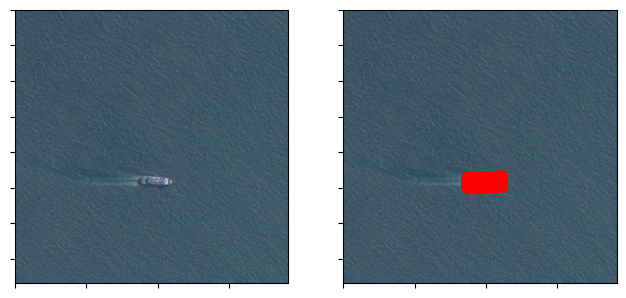

In [46]:
ship_coordinates = list(df.loc[2, 'EncodedPixels'].split())
ship_coordinates = [int(x) for x in ship_coordinates]
image_path = train_dir + df.loc[2, 'ImageId']
image = Image.open(image_path)

pixel_number = np.array(ship_coordinates[::2])
pixel_amount = np.array(ship_coordinates[1::2])
pixel_numbers = []

for i in range(len(pixel_amount)):
    for j in range(pixel_number[i], pixel_number[i] + pixel_amount[i]):
        pixel_numbers.append(j)

pixel_numbers = np.array(pixel_numbers)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(image)
plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
plt.subplot(132)
rows, cols = np.unravel_index(pixel_numbers - 1, image.size[:2])
plt.imshow(image)

plt.scatter(rows, cols, color='red', marker='o')

plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
plt.show()

In [40]:
sizes = []
for image in os.listdir(train_dir):
    image = plt.imread(train_dir+image)
    sizes.append(image.shape)

In [42]:
widths = [shape[0] for shape in sizes]
heights = [shape[1] for shape in sizes]
dimensions = [shape[2] for shape in sizes]

width_counts = dict(zip(*np.unique(widths, return_counts=True)))
height_counts = dict(zip(*np.unique(heights, return_counts=True)))
dimension_counts = dict(zip(*np.unique(dimensions, return_counts=True)))

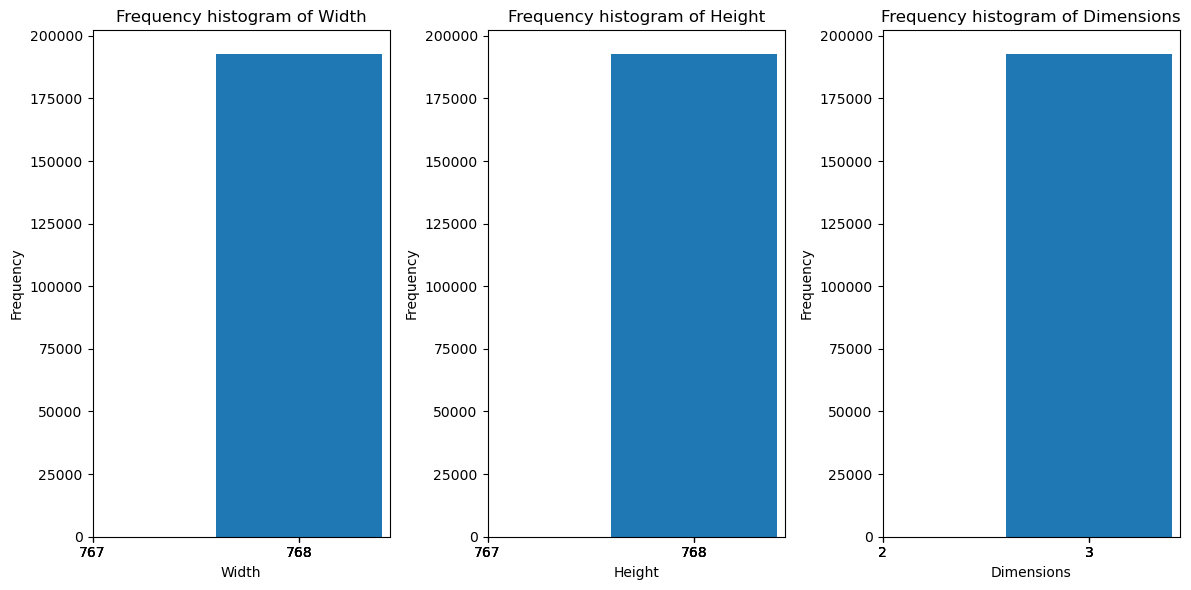

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.bar(width_counts.keys(), width_counts.values())
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Width')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.subplot(132)
plt.bar(height_counts.keys(), height_counts.values())
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Height')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.subplot(133)
plt.bar(dimension_counts.keys(), dimension_counts.values())
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Dimensions')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.tight_layout()

Important notes:
Disable augmentation 
Avoid destructive resizing
Always inspect the outputs visually